In [1]:
%load_ext line_profiler
%load_ext autoreload

import numpy as np

import tensorflow as tf
import neural_tangents as nt
from neural_tangents import stax

from jax.config import config; config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random, jit

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
def find_h(N, L, d, n=1, bias=True):
    # Modified from https://github.com/mariogeiger/nn_jamming/blob/master/constN.py
    # TODO: bias=False?
    '''
        For a network with: 
        
        d input dimensionality, 
        L layers, 
        N total parameters, 
        n final outputs,
        
        this finds the corresponding width h 
    '''
    assert L >= 1

    if L == 1:
        # solve : N = h*(d+1) + n*(h+1)
        h = (N - n) / (d + n + 1)
    else:
        # solve : N = h*(d+1) + (L-1)*h*(h+1) + n*(h+1)
        h = -(d+L+n - ((d+L+n)**2 + 4*(L-1)*(N-n))**.5)/(2*(L-1))
    return round(h)

def find_N(h, L, d, n=1):
    return h*(d+1) + (L-1)*h*(h+1) + n*(h+1)

Prepare data

In [40]:
# Load data from https://www.openml.org/d/554
from sklearn.datasets import fetch_openml
X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True)

In [41]:
P = 2500 #train
P_total = int(1.5*P)

X = X_raw[:P_total]
y = (2*(y_raw.astype(int) % 2) - 1)[:P_total].reshape(-1,1)

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1-P/P_total, random_state=42)
len(X_train)

2499

In [43]:
from sklearn.decomposition import PCA
n_components = 10
pca = PCA(n_components = n_components)
pca = pca.fit(X_train)

In [44]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# project to hyper-sphere of radius sqrt(n_components)
X_train = np.sqrt(n_components) * X_train / np.linalg.norm(X_train, axis = 1, keepdims=True)
X_test = np.sqrt(n_components) * X_test / np.linalg.norm(X_test, axis = 1, keepdims=True)

Prepare network

In [45]:
d = n_components
L = 2
N = 2*P

h = find_h(N, L, d)
N/P, h

(2.0, 65)

In [46]:
init_fn, apply_fn, kernel_fn_inf = stax.serial(
    *[stax.Dense(h), stax.Erf()]*L,
    stax.Dense(1)
)

In [47]:
initkey = random.PRNGKey(123)
_, init_params = init_fn(initkey, X_train.shape)

In [48]:
from jax.api import jacrev
from jax import tree_util

@jit
def jacobian_leaf_flattener(x):
    #Flatten everything but first two dimensions (batch_size, n_out)
    param_count = int(jnp.prod(x.shape[2:]))
    return jnp.reshape(x, x.shape[:2] + (param_count,))

def network_jacobian(apply_fn, params, inputs):
    """
        TODO: speed me up/find a way to @jit me?
    """
    jac = jacrev(apply_fn)(params, inputs)
    leaves, _ = tree_util.tree_flatten(jac)
    
    return jnp.concatenate([jacobian_leaf_flattener(leaf) for leaf in leaves], -1)

In [49]:
apply_fn = jit(apply_fn)
train_f0 = apply_fn(init_params, X_train)
test_f0 = apply_fn(init_params, X_test)

train_features = network_jacobian(apply_fn, init_params, X_train).reshape(len(X_train), -1)
test_features = network_jacobian(apply_fn, init_params, X_test).reshape(len(X_test), -1)

In [50]:
"""
    Minimizing squared hinge loss with small regularization on the weights. 
    This gives us an L2-regularized L2-loss SVM:
        https://www.csie.ntu.edu.tw/~cjlin/papers/liblinear.pdf#equation.A.2
"""
import liblinear
import liblinearutil
import os

lamb = 1e-8
C = 1/(P*lamb)

#Primal (-s 2) is faster in our case
model = liblinearutil.train(y_train.reshape(-1), np.array(train_features), f'-s 2 -n {os.cpu_count()} -c {C}')

In [51]:
p_label, p_acc, p_val = liblinearutil.predict(y_train.reshape(-1), np.array(train_features), model, '-q')

Text(0.5, 1.0, 'Train: 100% accuracy')

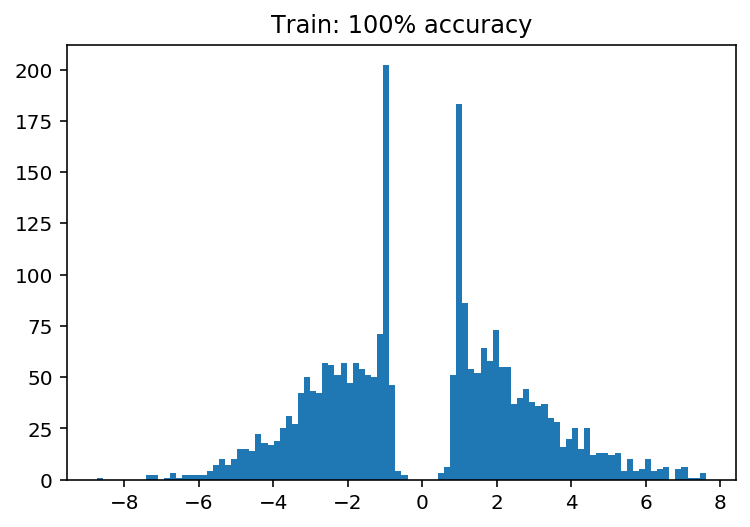

In [52]:
hist = plt.hist(np.ravel(p_val), bins = 100)
plt.title(f'Train: {p_acc[0]:.0f}% accuracy')

In [53]:
p_label, p_acc, p_val = liblinearutil.predict(y_test.reshape(-1), np.array(test_features), model, '-q')

Text(0.5, 1.0, 'Test: 89% accuracy')

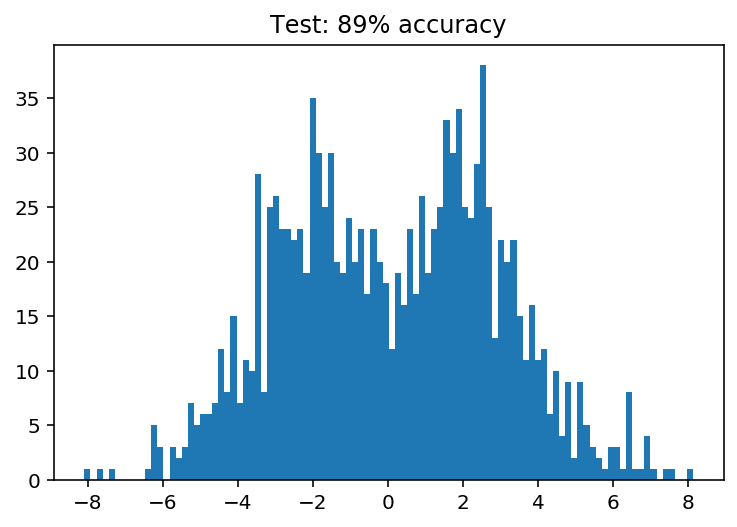

In [54]:
hist = plt.hist(np.ravel(p_val), bins = 100)
plt.title(f'Test: {p_acc[0]:.0f}% accuracy')

## Train loop

In [55]:
from tqdm import notebook as tqdm

In [56]:
results = []

for hi in tqdm.trange(h, 0, -1):
    Ni = find_N(hi, L, d)
    
    init_fn, apply_fn, kernel_fn_inf = stax.serial(
        *[stax.Dense(hi), stax.Erf()]*L,
        stax.Dense(1)
    )
    apply_fn = jit(apply_fn)
    _, init_params = init_fn(initkey, X_train.shape)

    train_features = network_jacobian(apply_fn, init_params, X_train).reshape(len(X_train), -1)    
    test_features = network_jacobian(apply_fn, init_params, X_test).reshape(len(X_test), -1)
    
    for lamb in np.logspace(-3,-15, 5):
        C = 1/(P*lamb)
        model = liblinearutil.train(y_train.reshape(-1), np.array(train_features), f'-s 2 -n {os.cpu_count()} -c {C}')

        train_p_label, train_p_acc, train_p_val = liblinearutil.predict(y_train.reshape(-1), np.array(train_features), model, '-q')
        test_p_label, test_p_acc, test_p_val = liblinearutil.predict(y_test.reshape(-1), np.array(test_features), model, '-q')
        
        result = {
            'N': Ni,
            'P': P,
            'lambda': lamb,
            'y_train': y_train.reshape(-1),
            'y_train_hat': np.array(train_p_val).reshape(-1),
            'y_test': y_test.reshape(-1),
            'y_test_hat': np.array(test_p_val).reshape(-1)
        }
        
        results.append(result)

In [3]:
import pandas as pd

In [4]:
# result_df = pd.DataFrame(results)
# result_df.to_json(open('results/mnist_hinge_NTK.json', 'w'))

In [5]:
result_df = pd.read_json(open('results/mnist_hinge_NTK.json', 'r'))

In [20]:
force = lambda y,f: 1 - y*f
loss = lambda y,f: np.mean(np.maximum(0, force(y,f))**2)
N_del = lambda y,f: np.sum(force(y,f) >= 0)
N_correct = lambda y,f: np.sum(y*f > 0)
N_incorrect = lambda y,f: np.sum(y*f < 0)

In [21]:
result_df['test_loss'] = np.vectorize(loss)(result_df.y_test, result_df.y_test_hat)
result_df['train_loss'] = np.vectorize(loss)(result_df.y_train, result_df.y_train_hat)
result_df['N_del'] = np.vectorize(N_del)(result_df.y_train, result_df.y_train_hat)

result_df['N/P'] = result_df['N']/result_df['P']
result_df['P/N'] = result_df['P']/result_df['N']
result_df['N_del/P'] = result_df['N_del']/result_df['P']
result_df['N_del/N'] = result_df['N_del']/result_df['N']


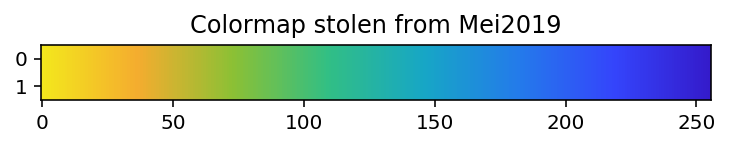

In [22]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list(
    'Mei2019', 
    np.array([
        (243, 232, 29),
        (245, 173, 47),
        (140, 193, 53),
        (50,  191, 133),
        (23,  167, 198),
        (36,  123, 235),
        (53,  69,  252),
        (52,  27,  203)
    ])/255., 
)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig = plt.figure(figsize=(6,.5))
img = plt.imshow(gradient, aspect='auto', cmap=cmap)
title = plt.title('Colormap stolen from Mei2019')

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


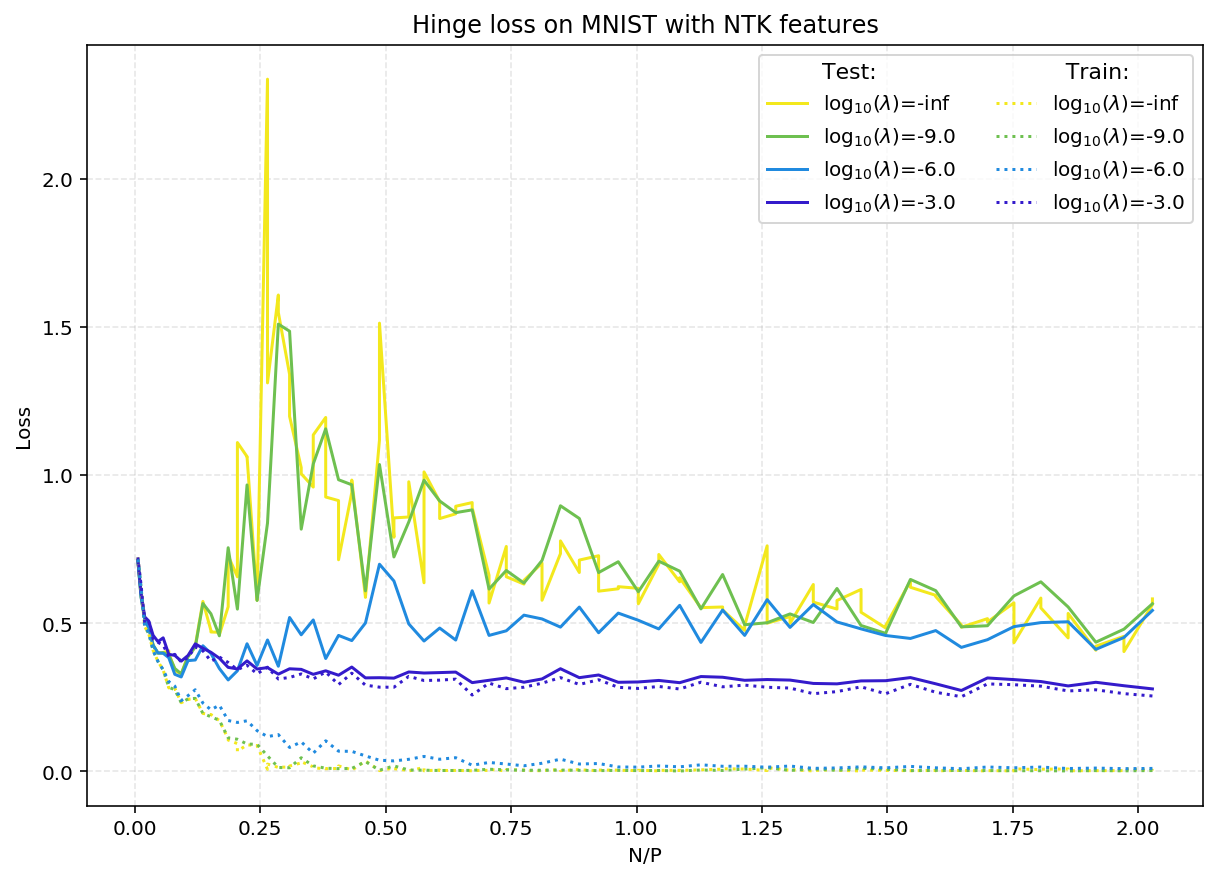

In [23]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N/P', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)))

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N/P', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), ls=':')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with NTK features')

fig.savefig('mnist_hinge_loss_ntk_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


Text(0.5, 1.0, 'Hinge loss on MNIST with CK features')

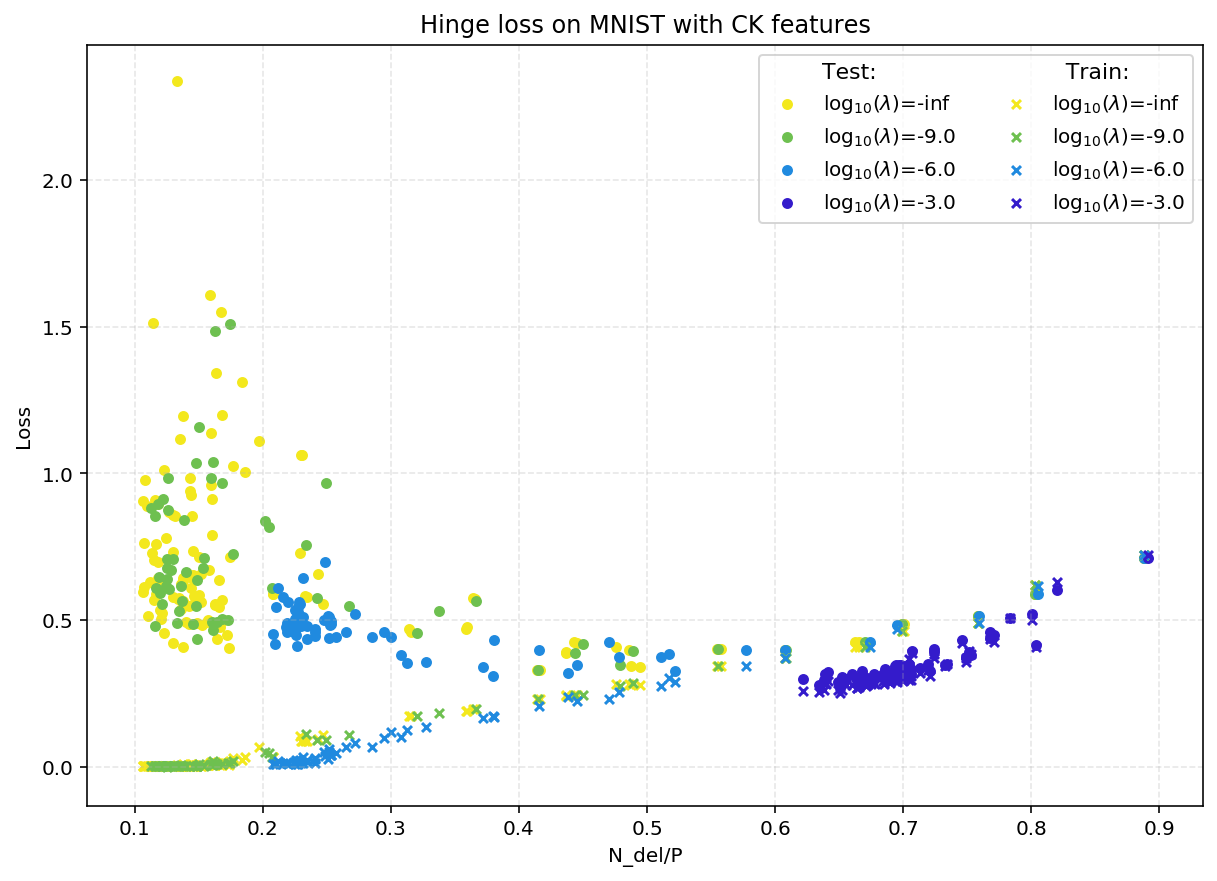

In [24]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/P', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/P', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')

# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


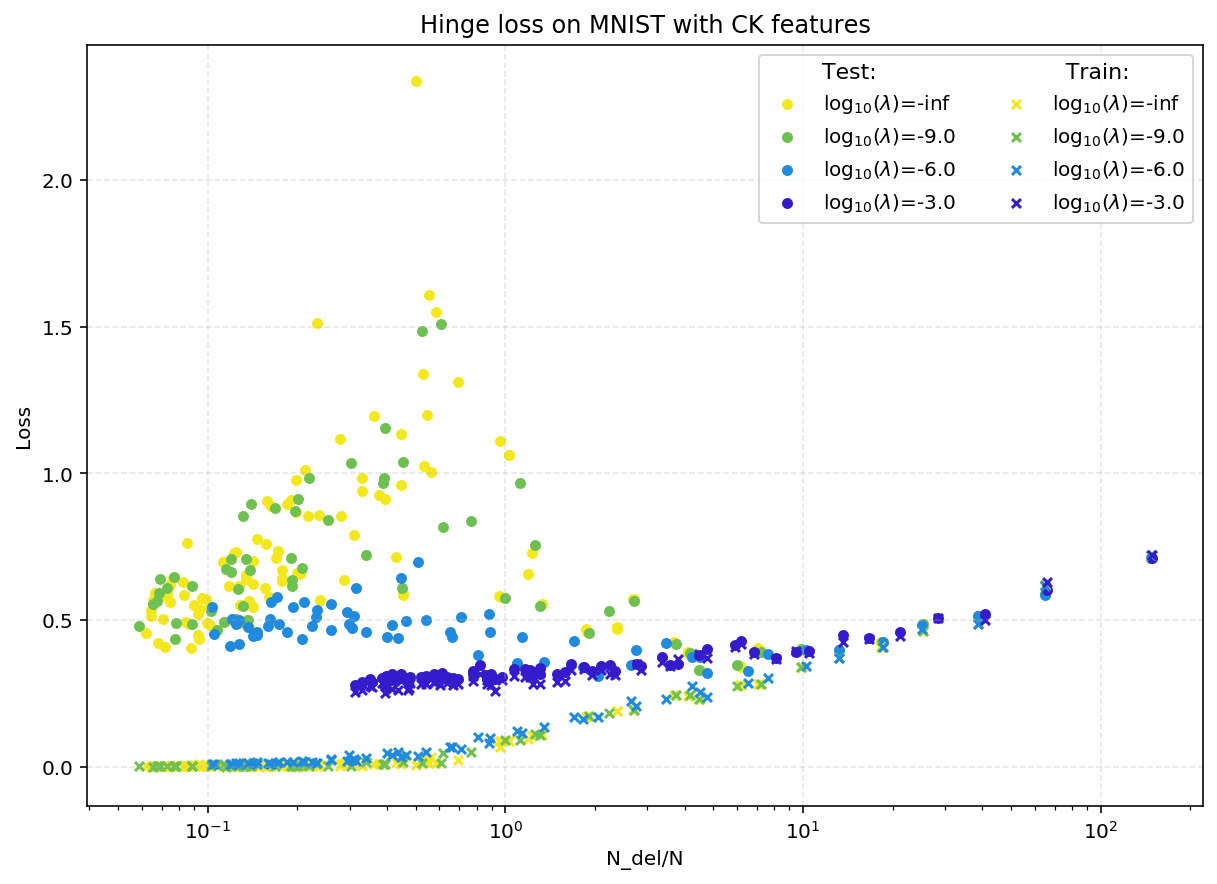

In [31]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.xscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


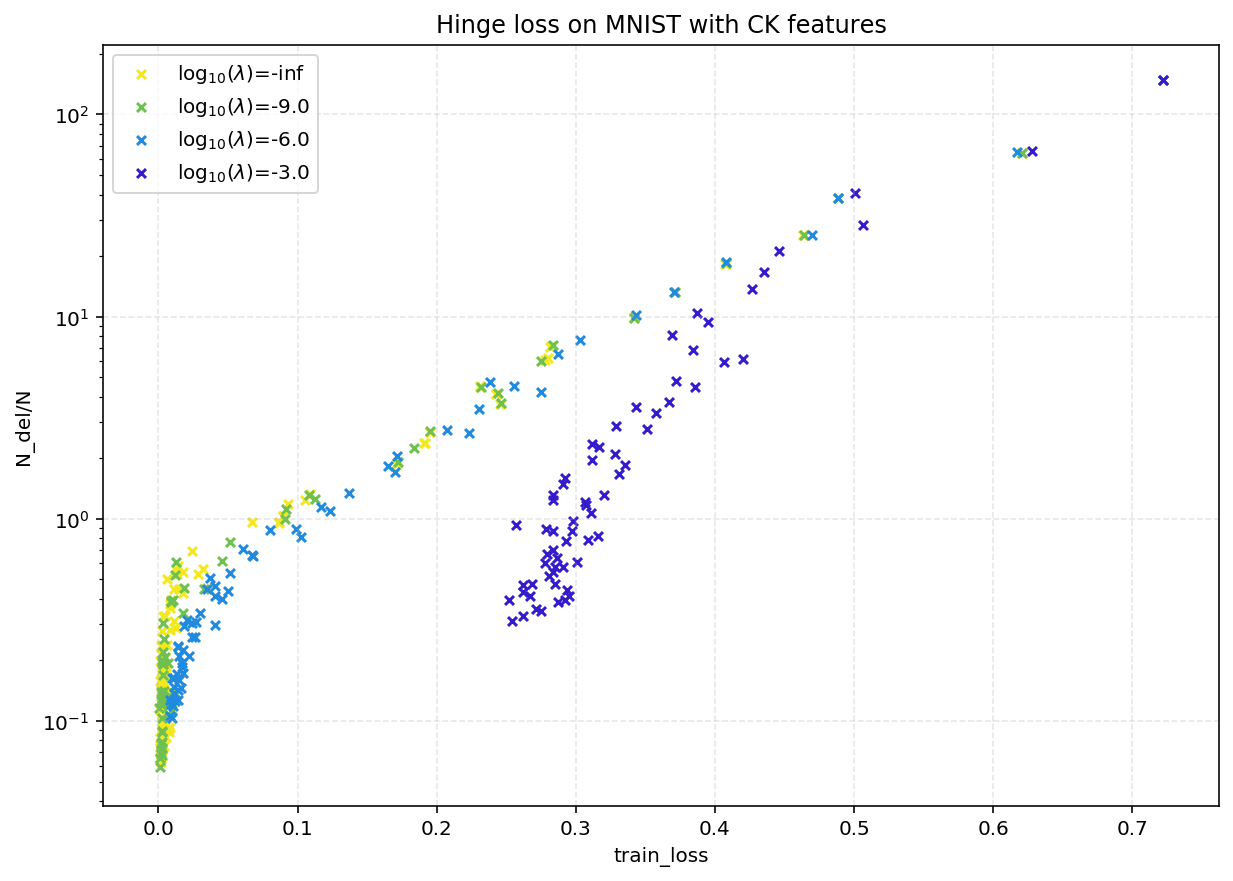

In [26]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('train_loss', 'N_del/N', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend()
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.yscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


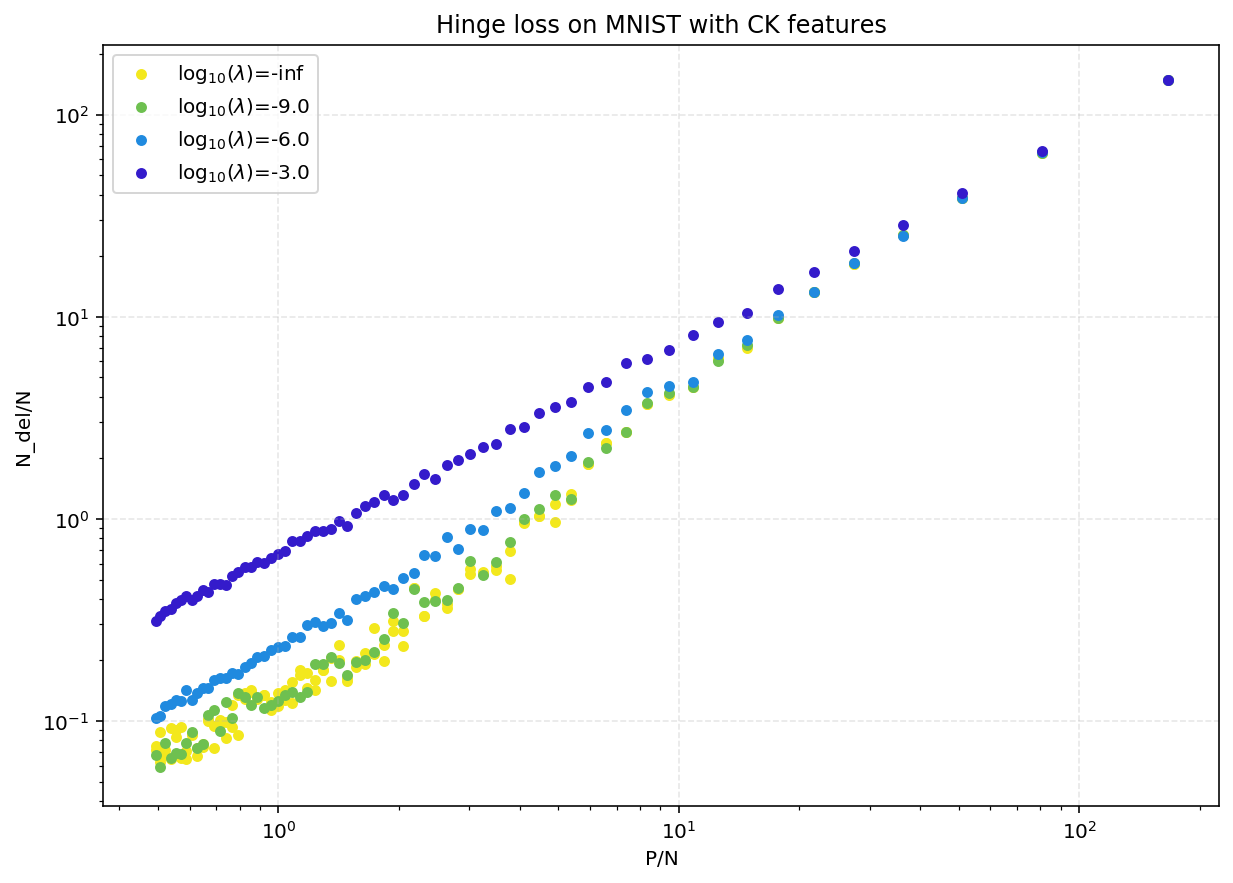

In [27]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'N_del/N', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

ax.legend()
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with NTK features')
plt.xscale('log')
plt.yscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


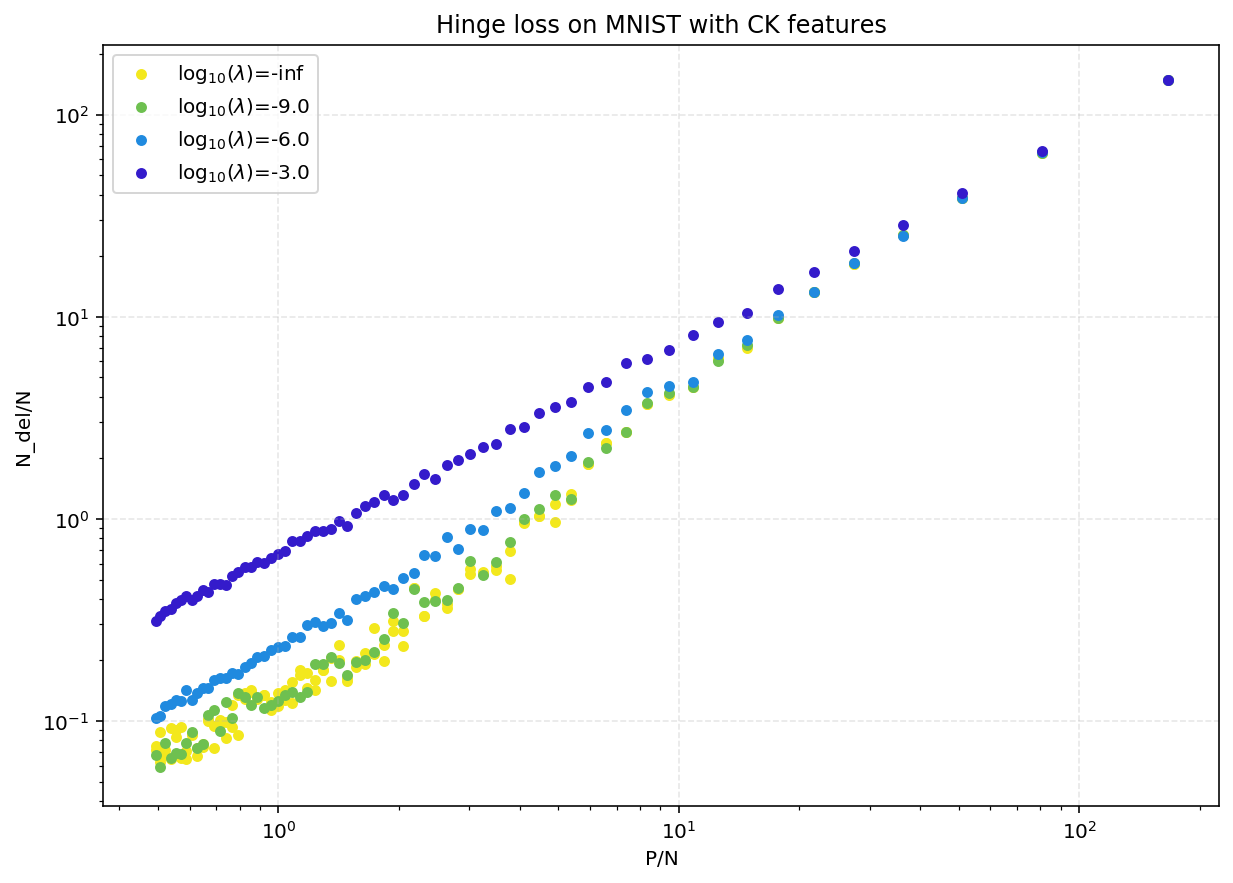

In [28]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'N_del/N', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')
# for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
#     df.plot('P/N', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

ax.legend()
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.yscale('log')
plt.xscale('log')

# plt.xlim(.5,10)
# plt.ylim(.05,7)
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


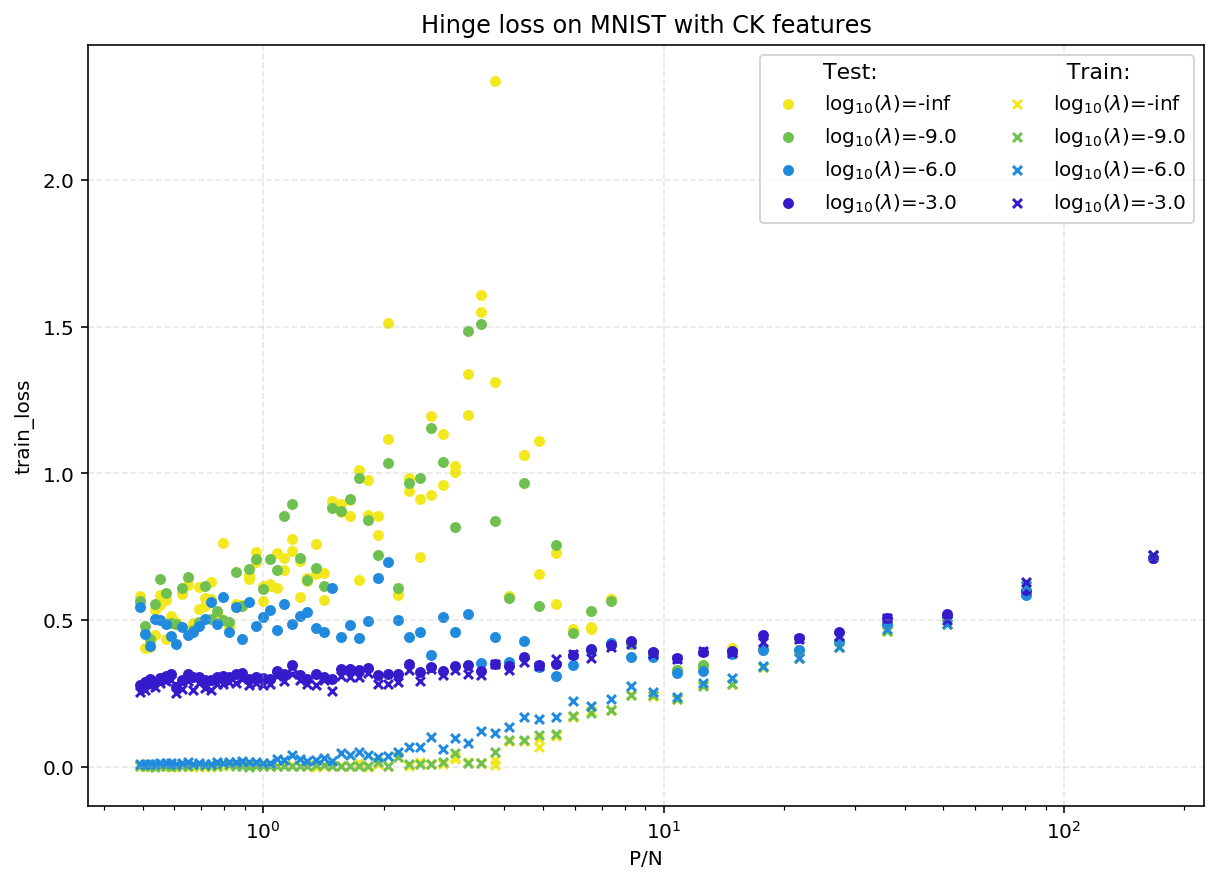

In [29]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'test_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('P/N', 'train_loss', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
# ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.xscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)

/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/Users/hudson_home/miniconda3/envs/thesis/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


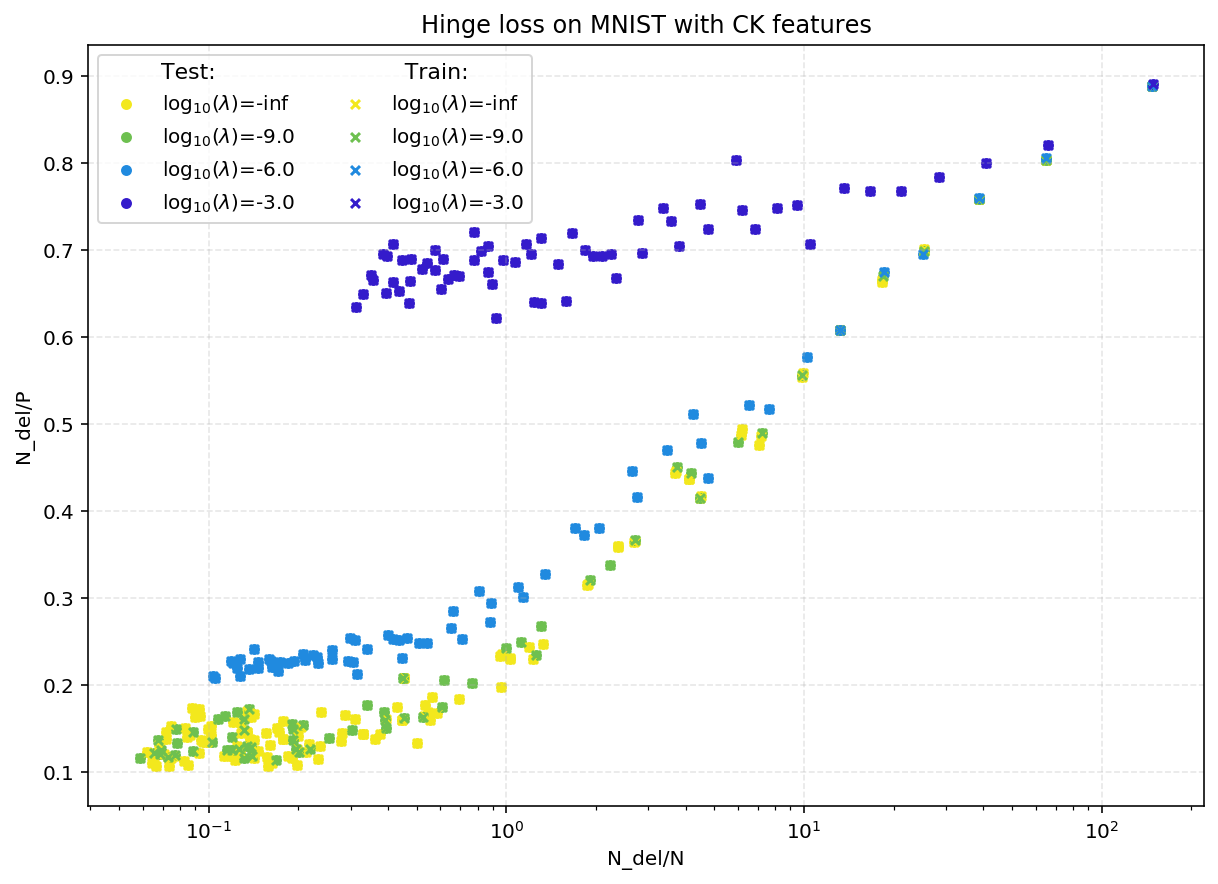

In [30]:
fig, ax = plt.subplots(figsize=(10,7))
n_colors = len(result_df['lambda'].unique())

#Test
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'N_del/P', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), kind='scatter')

#Train
for i, (lamb, df) in enumerate(result_df.groupby('lambda')):
    df.plot('N_del/N', 'N_del/P', label='$\log_{10}(\lambda)$='+f'{np.log10(lamb):.1f}', ax=ax, color=cmap(float(i)/(n_colors-1)), marker='x', kind='scatter')

ax.legend(ncol=2, title='Test:                           Train:', title_fontsize=11)
# ax.set_ylabel('Loss')
ax.grid(True, ls='--', alpha=.3)
ax.set_title('Hinge loss on MNIST with CK features')
plt.xscale('log')
# fig.savefig('mnist_hinge_loss_ck_features_regularized.png', dpi=300)